accuracyが0.63、LightGBMでもXgboostでもほぼ変わらず
LIMEのパラメータ(kernelなど)によって、結果が変わる。
LIMEとpdpの扱えるデータ形式が違うので注意
feature importanceが高い変数ほどpdpの変動が大きかった。

# ハンズオンサンプルコード

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from pdpbox import pdp, get_dataset, info_plots
import lime
import lime.lime_tabular

/Users/suzukihiroto/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## データの読み込み

In [2]:
train_df = pd.read_csv('../../data/train.csv')
train_df.head()

,class,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount
0,5,45.42,1.059,1.01400,5.88,53.01,4.18,56.78,60,1.047,78.0,1.5,Specific Gravity,All Grain,0.5,18.33,NaN,NaN
1,4,19.87,1.065,1.01300,7.20,52.40,5.31,23.66,60,1.055,75.0,1.5,Specific Gravity,All Grain,NaN,NaN,NaN,NaN
2,1,21.00,17.996,3.43912,7.96,61.19,8.65,24.00,60,15.900,77.0,3.0,Plato,All Grain,NaN,20.00,NaN,NaN
3,3,11.36,1.084,1.02300,8.08,58.40,8.41,13.25,60,1.072,70.0,NaN,Specific Gravity,Partial Mash,NaN,17.78,NaN,NaN
4,1,20.82,1.063,1.01400,6.49,70.14,3.99,27.25,60,1.048,35.0,NaN,Specific Gravity,extract,NaN,18.89,NaN,NaN


In [3]:
# データ型の確認
train_df.dtypes

class              int64
Size(L)          float64
OG               float64
FG               float64
ABV              float64
IBU              float64
Color            float64
BoilSize         float64
BoilTime           int64
BoilGravity      float64
Efficiency       float64
MashThickness    float64
SugarScale        object
BrewMethod        object
PitchRate        float64
PrimaryTemp      float64
PrimingMethod     object
PrimingAmount     object
dtype: object

In [4]:
# NULLの確認
train_df.isnull().sum()

class                0
Size(L)              0
OG                   0
FG                   0
ABV                  0
IBU                  0
Color                0
BoilSize             0
BoilTime             0
BoilGravity        958
Efficiency           0
MashThickness    10896
SugarScale           0
BrewMethod           0
PitchRate        14549
PrimaryTemp       8263
PrimingMethod    24460
PrimingAmount    25083
dtype: int64

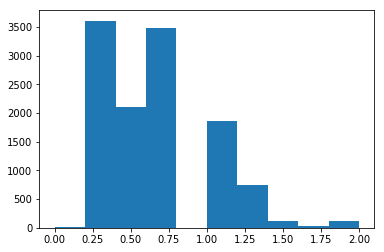

In [5]:
plt.hist(train_df['PitchRate']);

In [6]:
# 使用するカラムを以下の6つに限定（最初のclassは目的変数）
USE_COLUMNS = ['class', 'OG', 'FG', 'ABV', 'IBU', 'Color', 'BoilSize', 'Size(L)', 'BoilTime', 'Efficiency']
USE_FEATURES = ['OG', 'FG', 'ABV', 'IBU', 'Color', 'BoilSize', 'Size(L)', 'BoilTime', 'Efficiency']

# 欠損値をゼロ埋めする
train_df = train_df.loc[:,USE_COLUMNS].fillna(0)

df_train, df_eval = train_test_split(train_df, test_size=0.2, random_state=2019)

train_X = np.array(df_train.loc[:,USE_FEATURES])
eval_X = np.array(df_eval.loc[:,USE_FEATURES])
train_y = np.array(df_train.iloc[:,0])
eval_y = np.array(df_eval.iloc[:,0])


In [7]:
df_train.loc[:,'class'].value_counts()

1     7667
2     4756
4     1688
10    1466
7     1297
5     1136
3      971
8      812
9      792
6      731
Name: class, dtype: int64

In [8]:
df_eval.loc[:,'class'].value_counts()

1     1904
2     1230
4      416
10     360
7      329
5      272
3      252
8      208
6      185
9      174
Name: class, dtype: int64

In [9]:
# ダミー変数化　欠損値なし
def one_hot_encode(ohe_columns, X_train):
    X_ohe = pd.get_dummies(X_train, columns=ohe_columns)
    return X_ohe

## 学習

In [10]:
# パラメータは特にいじらず学習
model = LGBMClassifier(num_leaves=7, learning_rate=0.05, n_estimators=500, random_state=0)
model.fit(train_X, train_y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.05, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=500, n_jobs=-1, num_leaves=7, objective=None,
        random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [11]:
# ひとまずローカルバリデーション。あまり結果はよくない。
y_pred = model.predict(eval_X)
accuracy = accuracy_score(y_pred, eval_y)
print('Accuracy: {:3f}'.format(accuracy))

Accuracy: 0.636210


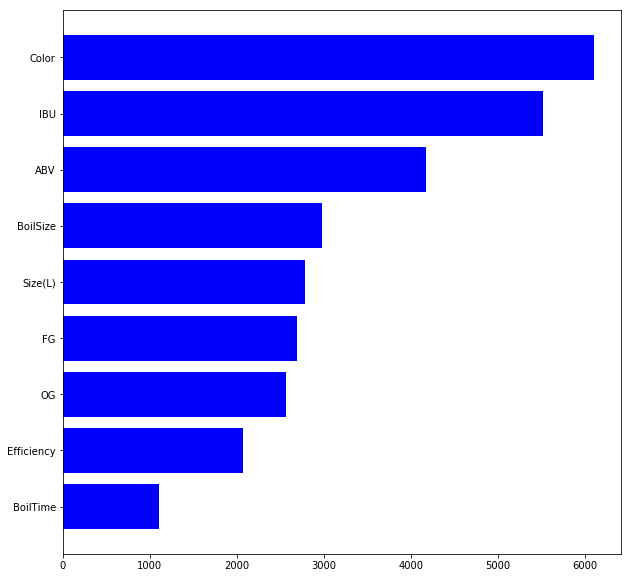

In [12]:
# feature importance
features = train_df.loc[:,USE_FEATURES].columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,10))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

feature importancesを確認したところIBU（苦味の指標）, Colorの重要度が大きくついでABV（アルコール度数みたいなもの）が大きい。   


In [13]:
# 結果表示用にラベルのcsvを取り込む
class_df = pd.read_csv('../../data/class_ids.csv')
class_df.head()
beer_dict = {}

for i in range(class_df.shape[0]):
    beer_dict[class_df.loc[i,'class_ids']] = class_df.loc[i,'Style']
beer_list = class_df.sort_values('class_ids').Style.unique()

In [14]:
beer_dict

{1: 'American IPA',
 2: 'American Pale Ale',
 3: 'Imperial IPA',
 4: 'Saison',
 5: 'Blonde Ale',
 6: 'American Brown Ale',
 7: 'American Amber Ale',
 8: 'American Stout',
 9: 'Irish Red Ale',
 10: 'American Light Lager'}

In [15]:
# LIMEで予測結果を確認
explainer = lime.lime_tabular.LimeTabularExplainer(train_X, feature_names=USE_COLUMNS, class_names=beer_list)

In [16]:
i = np.random.randint(0, eval_y.shape[0])
pred_beer = beer_dict[eval_y[i]]

print('True Value: {}'.format(pred_beer))

exp = explainer.explain_instance(eval_X[i], model.predict_proba, num_features=len(train_df.iloc[:,1:].columns), top_labels=1)
exp.show_in_notebook(show_table=True, show_all=True)


True Value: American IPA


In [29]:
explainer4 = lime.lime_tabular.LimeTabularExplainer(train_X, feature_names=USE_COLUMNS, 
                                                    class_names=beer_list, kernel_width=0.2, feature_selection ='lasso_path')

i = np.random.randint(0, eval_y.shape[0])
pred_beer = beer_dict[eval_y[i]]

print('True Value: {}'.format(pred_beer))

exp4 = explainer4.explain_instance(eval_X[i], model.predict_proba, num_features=len(train_df.iloc[:,1:].columns), top_labels=1)
exp4.show_in_notebook(show_table=True, show_all=True)


True Value: American IPA


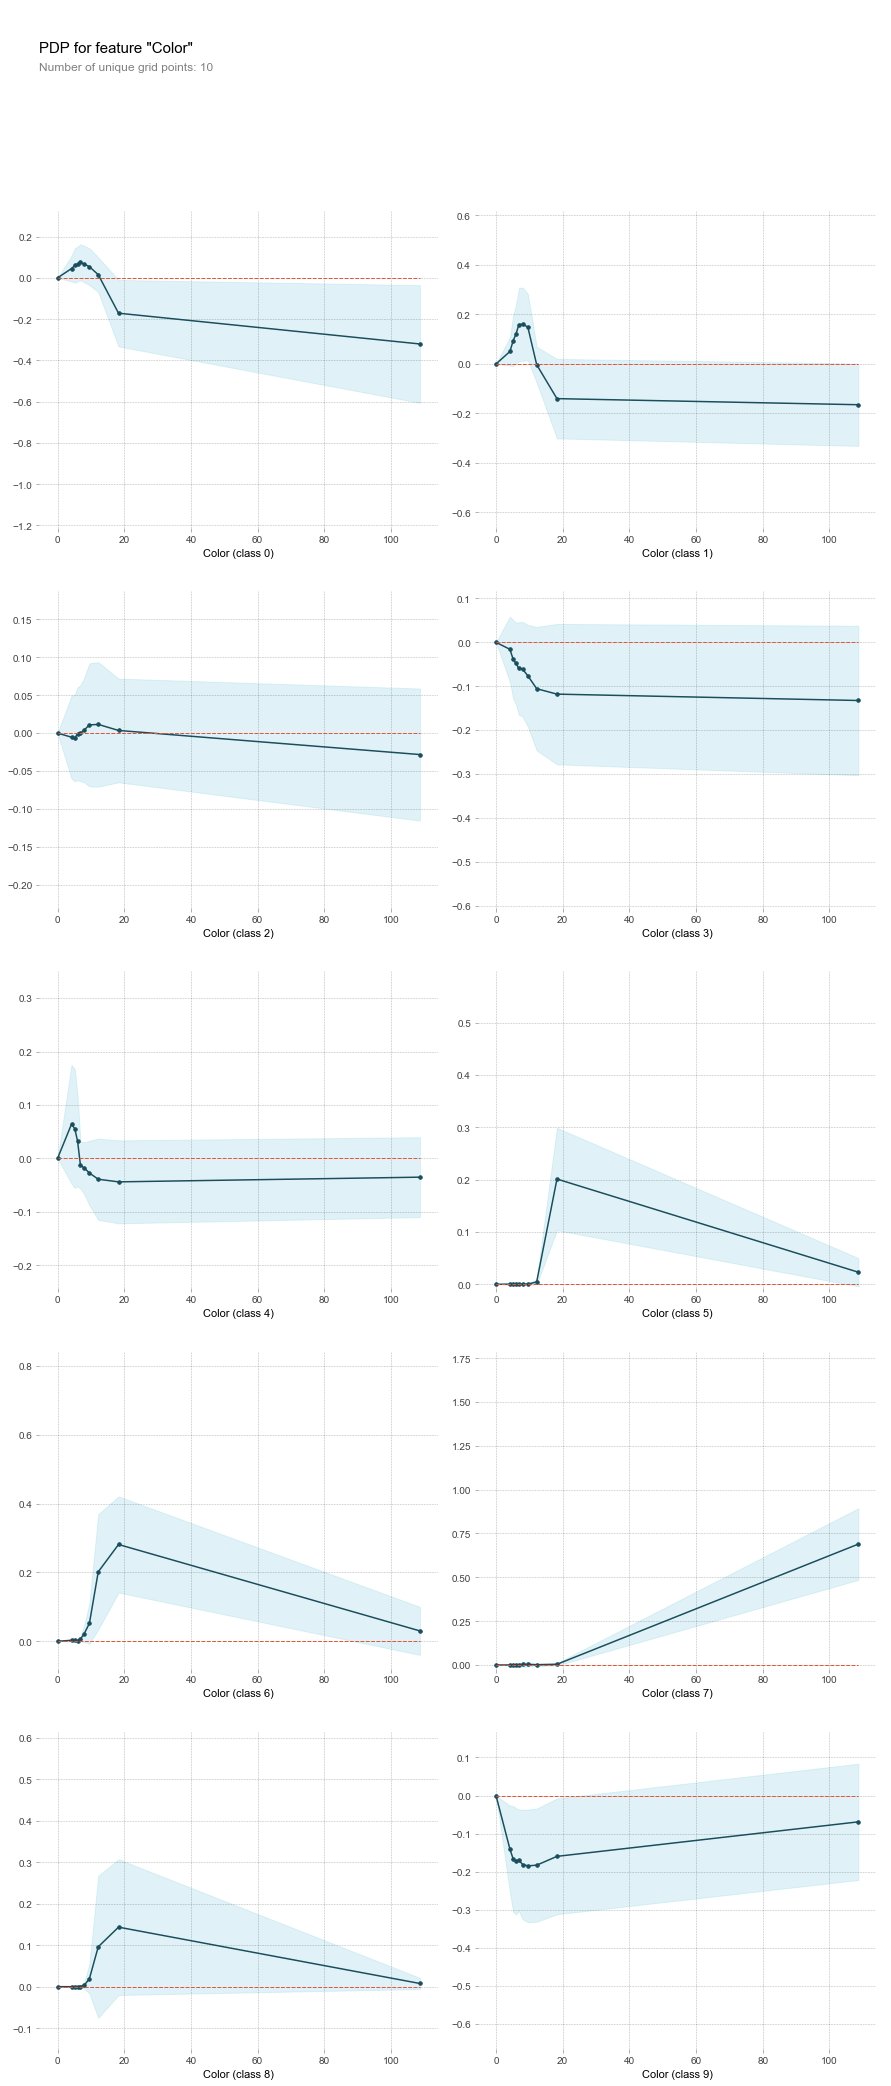

In [27]:
# Partial Dependence Plot
features = df_train.loc[:,USE_FEATURES].columns.values
feature_to_plot = 'Color'
pdp_goals = pdp.pdp_isolate(model=model, dataset=df_train.loc[:,USE_FEATURES], model_features=list(features), feature=feature_to_plot)

# PDPの実行
pdp.pdp_plot(pdp_goals, feature_to_plot)
plt.show()

## エラー分析
まずどのクラスにおいてエラーが多かったのか確認する

In [25]:
result_df = pd.DataFrame(y_pred, columns=['prediction'])
df_eval_result = pd.concat([df_eval.reset_index(drop=True), result_df], axis=1)
df_eval_result.head(100)

,class,OG,FG,ABV,IBU,Color,BoilSize,Size(L),BoilTime,Efficiency,prediction
0,5,1.0420,1.00700,4.62,17.13,3.18,28.40,25.00,90,75.0,5
1,10,1.0620,1.01500,6.06,59.87,7.79,47.32,40.69,60,75.0,1
2,1,1.0710,1.01800,7.01,0.00,7.61,51.10,41.64,75,70.0,1
3,2,1.0460,1.00800,5.00,57.30,14.12,30.00,21.00,60,35.0,7
4,1,1.0710,1.01600,7.24,69.98,9.05,11.36,18.93,60,35.0,1
5,4,1.0480,1.00800,5.21,43.08,5.40,28.39,18.93,60,35.0,2
6,1,1.0580,1.01100,6.17,65.33,4.86,53.00,41.64,60,74.0,1
7,5,1.0460,1.01100,4.55,21.62,4.83,11.36,18.93,60,35.0,5
8,1,1.0680,1.01500,6.96,241.04,7.03,28.39,20.82,60,70.0,1
9,3,1.0790,1.01400,8.46,109.45,8.99,30.00,21.00,90,70.0,3


In [19]:
#正答率データの作成
result_true = df_eval_result[df_eval_result['class']==df_eval_result['prediction']]
result_false = df_eval_result[df_eval_result['class']!=df_eval_result['prediction']]

result_true.loc[:,'class'] = result_true.loc[:,'class'].map(beer_dict)
result_false.loc[:,'class'] = result_false.loc[:,'class'].map(beer_dict)


In [20]:
result_true.sort_values('class').loc[:,'class'].value_counts()

American IPA            1486
American Pale Ale        778
Saison                   193
American Stout           185
Blonde Ale               159
Imperial IPA             149
American Amber Ale       139
American Brown Ale       111
Irish Red Ale             97
American Light Lager      94
Name: class, dtype: int64

In [21]:
result_false.sort_values('class').loc[:,'class'].value_counts()

American Pale Ale       452
American IPA            418
American Light Lager    266
Saison                  223
American Amber Ale      190
Blonde Ale              113
Imperial IPA            103
Irish Red Ale            77
American Brown Ale       74
American Stout           23
Name: class, dtype: int64

In [22]:
true_cnt = result_true.sort_values('class').loc[:,'class'].value_counts()
false_cnt = result_false.sort_values('class').loc[:,'class'].value_counts()

result_df_new = pd.concat([true_cnt, false_cnt],axis=1)
result_df_new.columns = ['true', 'false']


In [23]:
result_df_new.loc[:,'ratio'] = result_df_new.apply(lambda x: x.loc['true'] / (x.loc['true']+x.loc['false']), axis=1)
result_df_new.head(10)


,true,false,ratio
American Amber Ale,139,190,0.422492
American Brown Ale,111,74,0.600000
American IPA,1486,418,0.780462
American Light Lager,94,266,0.261111
American Pale Ale,778,452,0.632520
American Stout,185,23,0.889423
Blonde Ale,159,113,0.584559
Imperial IPA,149,103,0.591270
Irish Red Ale,97,77,0.557471
Saison,193,223,0.463942


[Text(0, 0, 'American Amber Ale'),
 Text(0, 0, 'American Brown Ale'),
 Text(0, 0, 'American IPA'),
 Text(0, 0, 'American Light Lager'),
 Text(0, 0, 'American Pale Ale'),
 Text(0, 0, 'American Stout'),
 Text(0, 0, 'Blonde Ale'),
 Text(0, 0, 'Imperial IPA'),
 Text(0, 0, 'Irish Red Ale'),
 Text(0, 0, 'Saison')]

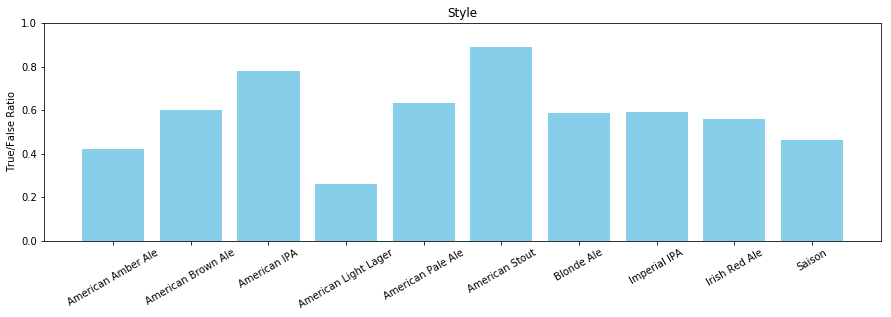

In [24]:
fig, ax = plt.subplots()
fig.set_figwidth(15)

true_false_ratio = np.array(result_df_new.loc[:,'ratio'])
ax.bar(np.arange(0,10),true_false_ratio, color='SkyBlue')

ax.set_ylim(0,1.0)
ax.set_ylabel('True/False Ratio')
ax.set_title('Style')
ax.set_xticks(np.arange(0,10))
ax.set_xticklabels(result_df_new.index,rotation=30)
